# Exploratory Data Analysis for SETI Signal Detection

In this notebook, we will explore the dataset provided by the Breakthrough Listen team and gain insights into the data to help us develop an effective algorithm for detecting potential technosignatures of extraterrestrial intelligence.


In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [2]:
# Import custom dataset class
from dataset import SETIDataset

In [3]:
# Load the dataset
root_dir = "E:\seti-breakthrough-listen\\train"
labels_csv = "E:\seti-breakthrough-listen\\train_labels.csv"

dataset = SETIDataset(root_dir=root_dir, labels_csv=labels_csv)  # Create the dataset object

In [4]:
# Split the dataset into train and validation sets
train_indices, val_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42, stratify=dataset.labels.iloc[:, 1])

train_dataset = SETIDataset(root_dir=root_dir, labels_csv=labels_csv)
val_dataset = SETIDataset(root_dir=root_dir, labels_csv=labels_csv)

In [5]:
# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, sampler=torch.utils.data.SubsetRandomSampler(train_indices), num_workers=4, prefetch_factor=2)
val_dataloader = DataLoader(val_dataset, batch_size=32, sampler=torch.utils.data.SubsetRandomSampler(val_indices), num_workers=4, prefetch_factor=2)

In [6]:
# Check the distribution of labels
label_counts = dataset.labels.iloc[:, 1].value_counts()
print("Label distribution:")
print(label_counts)

Label distribution:
0    54000
1     6000
Name: target, dtype: int64


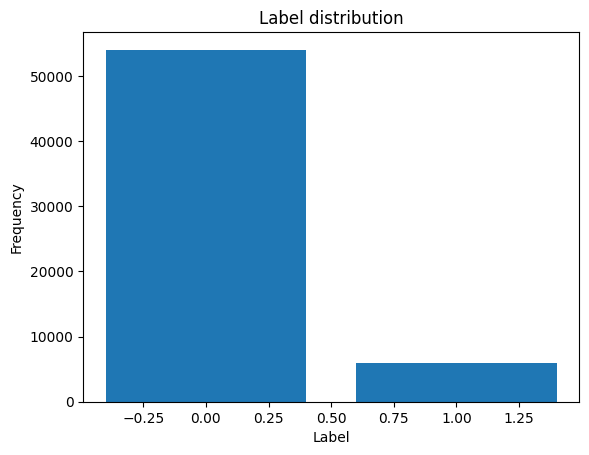

In [7]:
plt.bar(label_counts.index, label_counts.values)
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.title("Label distribution")
plt.show()

In [8]:
# Function to plot a spectrogram
def plot_spectrogram(spectrogram, title):
    plt.figure(figsize=(12, 6))
    plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
    plt.xlabel('Frequency Channels')
    plt.ylabel('Time Steps')
    plt.title(title)
    plt.colorbar(label='Signal Intensity')
    plt.show()

file_path: E:\seti-breakthrough-listen\train\0\0000799a2b2c42d.npy
file_path: E:\seti-breakthrough-listen\train\0\00042890562ff68.npy
file_path: E:\seti-breakthrough-listen\train\0\0005364cdcb8e5b.npy
file_path: E:\seti-breakthrough-listen\train\0\0007a5a46901c56.npy
file_path: E:\seti-breakthrough-listen\train\0\0009283e145448e.npy
file_path: E:\seti-breakthrough-listen\train\0\00096524e6670d6.npy


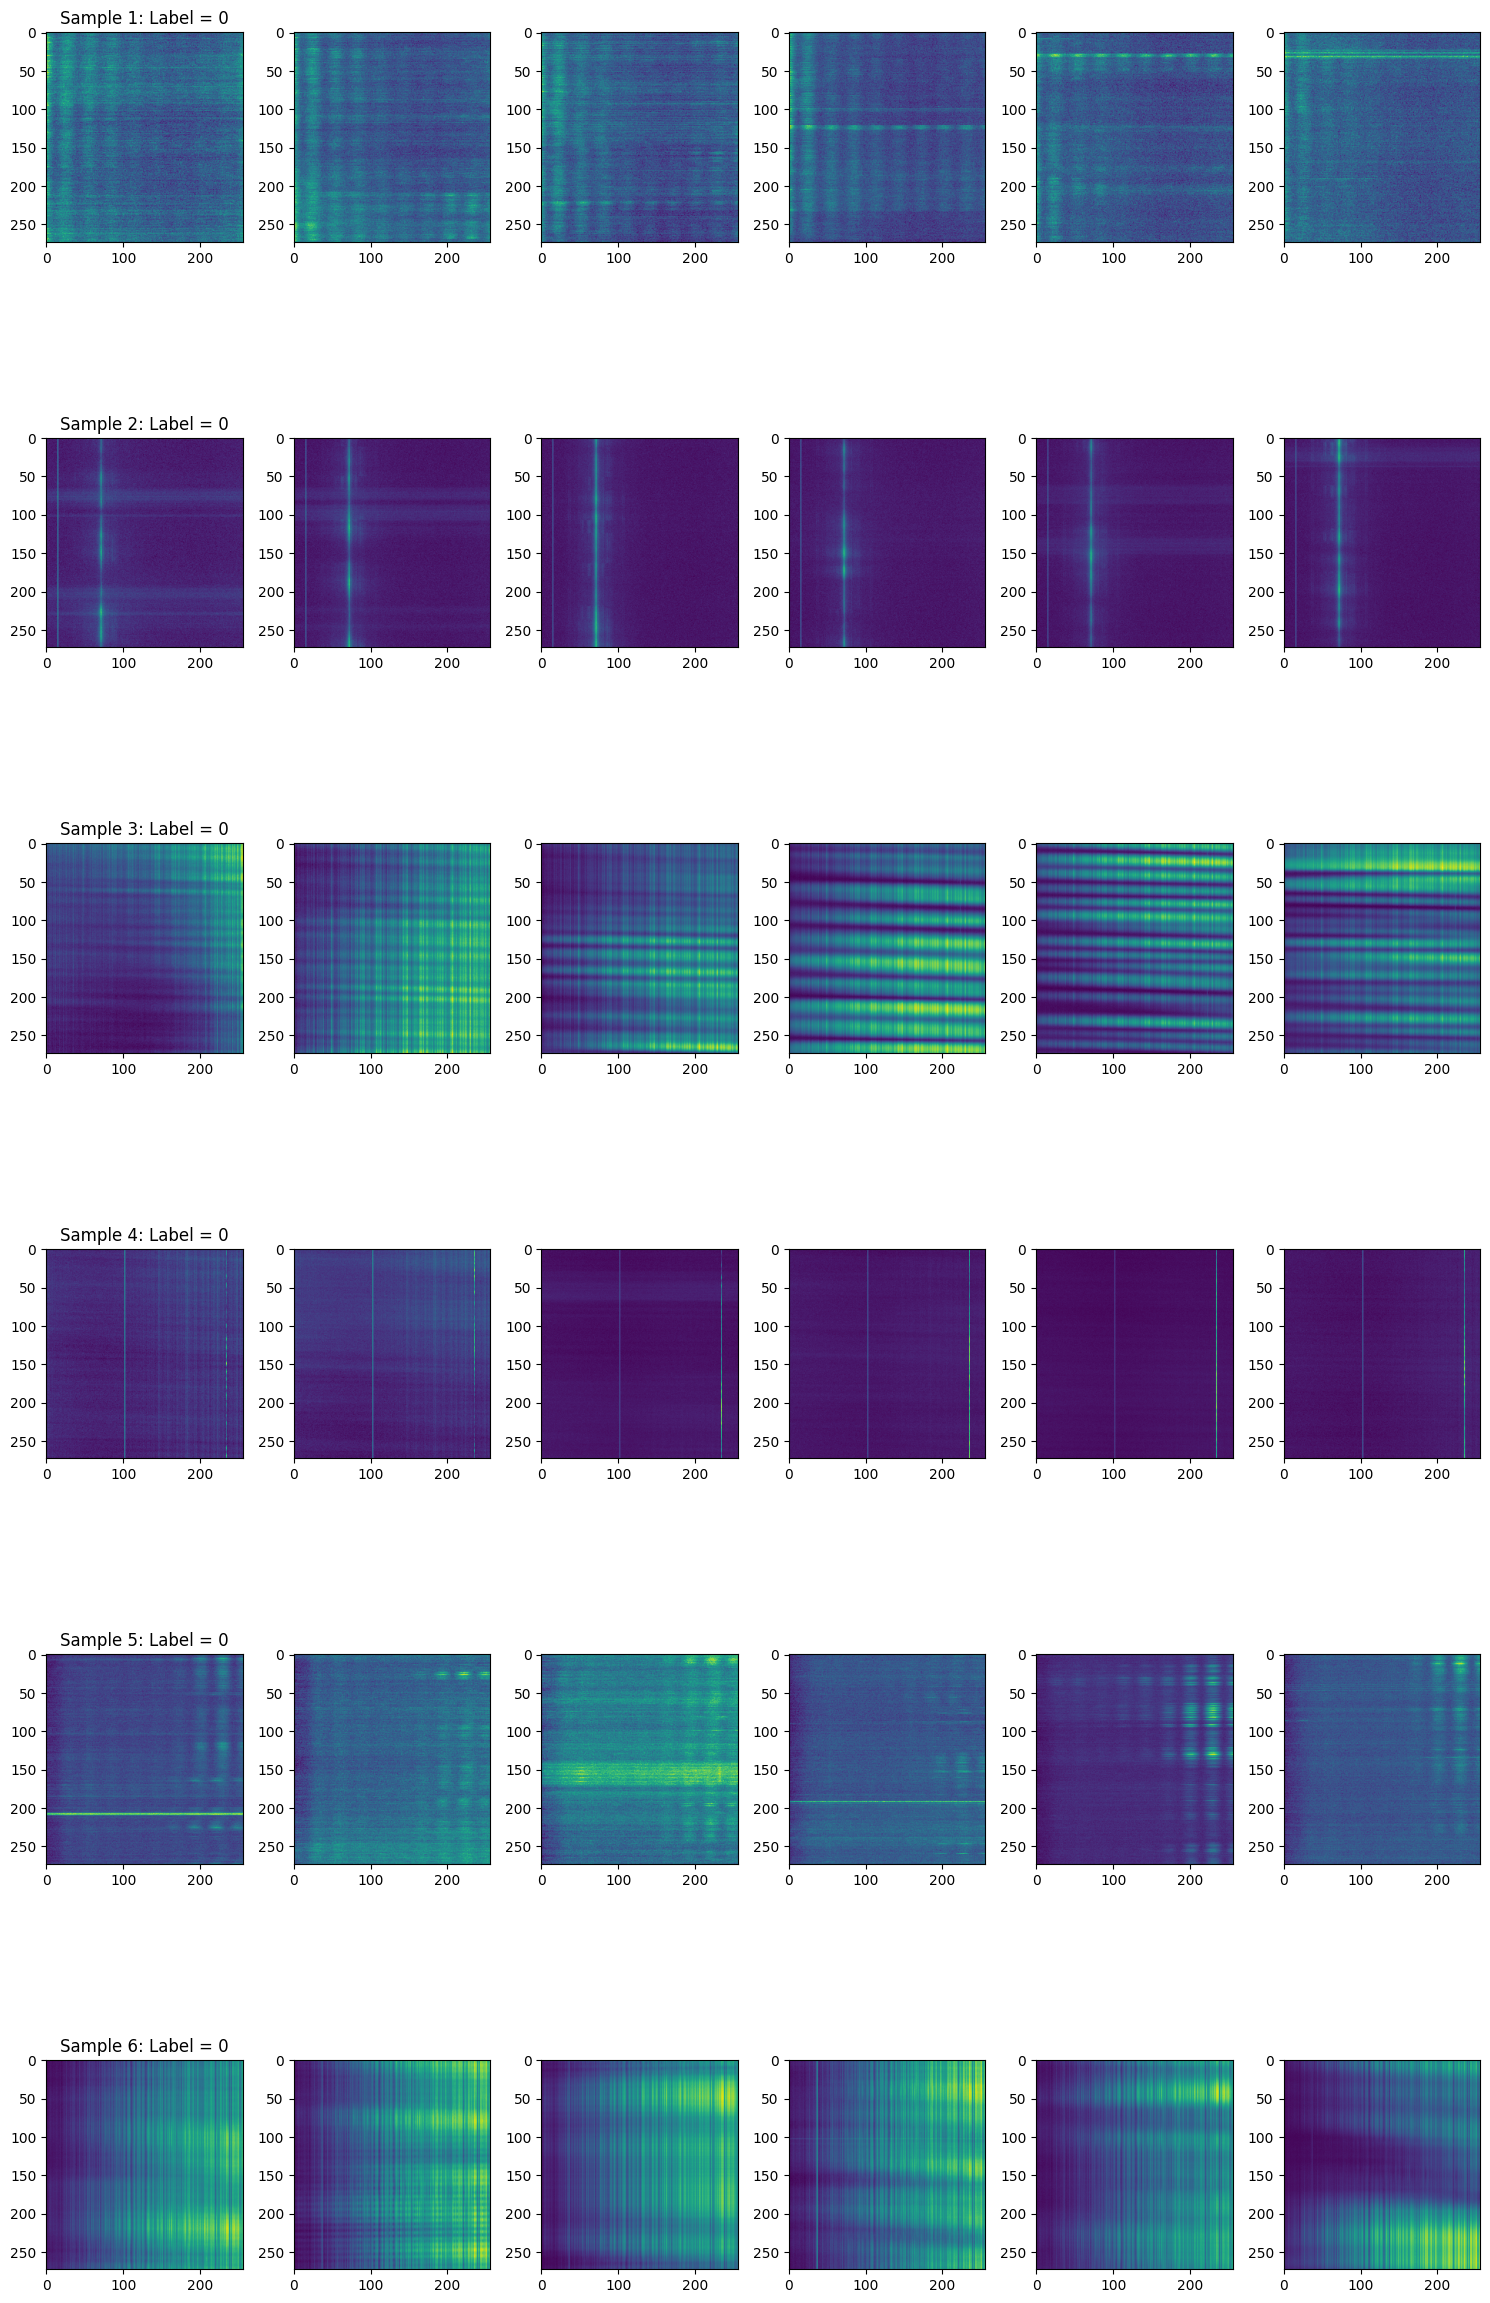

In [11]:
num_examples = 6
num_channels = 6
fig, axs = plt.subplots(num_examples, num_channels, figsize=(15, 25))

for i in range(num_examples):
    data, label = dataset[i]
    for ch in range(num_channels):
        axs[i, ch].imshow(data[ch], cmap="viridis")
        if ch == 0:
            axs[i, ch].set_title(f"Sample {i+1}: Label = {label}")

plt.tight_layout()
plt.show()


file_path: E:\seti-breakthrough-listen\train\c\c21e3967ee997b9.npy


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

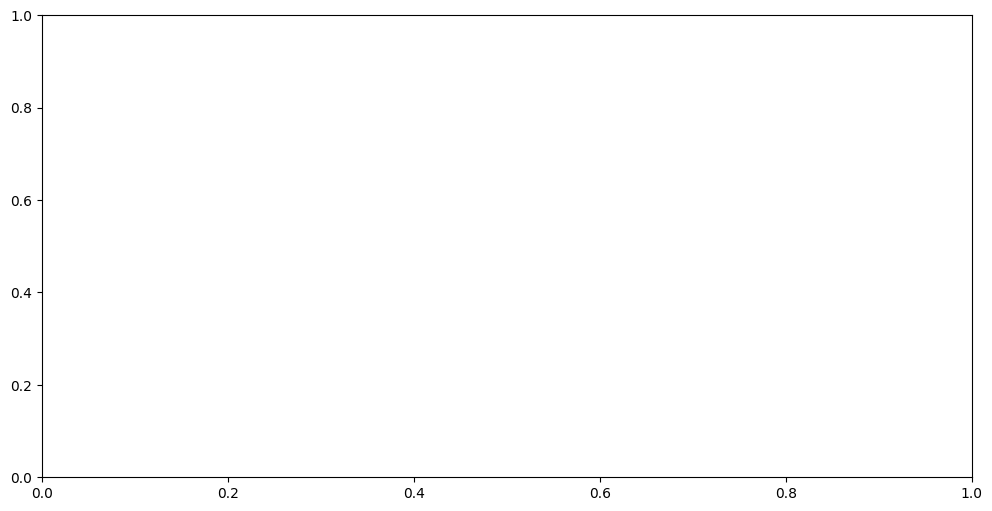

In [12]:
# Plot a random spectrogram from the training data
index = np.random.randint(len(train_dataset))
plot_spectrogram(train_dataset[index], 'Sample Spectrogram from Training Data')